In [15]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as reg
import keras_tuner as kt
import numpy as np

import kaggle_functions as kaggle
import importlib
importlib.reload(kaggle);

In [16]:
train_dataset, valid_dataset, valid_labels = kaggle.load_train_as_dataset()
x_test_real = kaggle.load_test_set()

batch_size = 128
train_dataset_augmented, epoch_length = kaggle.augment_dataset(train_dataset, batch_size)

model_number = 'model8'

Cause: could not parse the source code of <function augment_dataset.<locals>.<lambda> at 0x0000026BD78BC3A0>: no matching AST found among candidates:
# coding=utf-8
lambda image, y: (augmentation(image, training=True), y)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function augment_dataset.<locals>.<lambda> at 0x0000026BD78BC3A0>: no matching AST found among candidates:
# coding=utf-8
lambda image, y: (augmentation(image, training=True), y)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


### VGG-style with residual blocks

In [8]:
class VGGRes(kt.HyperModel):
    def residual_module(self, input, filters, stride=1, bottleneck=0, l2_reg=0.00001, batch_norm=0.99):
        # Applies bottleneck if necessary, to reduce dimensions
        if bottleneck > 0:
            conv_0 = layers.Conv2D(
                bottleneck, kernel_size=(1,1),
                padding='same', activation='relu',
                kernel_regularizer=reg.l2(l2_reg), bias_regularizer=reg.l2(l2_reg),
                kernel_initializer='he_normal')(input)
        else:
            bottleneck = filters
            conv_0 = input

        # Applies relu convolution, then linear convolution before shortcut
        conv_1 = layers.Conv2D(
            bottleneck, kernel_size=(3,3), strides=(stride, stride),
            padding='same', activation='relu',
            kernel_regularizer=reg.l2(l2_reg), bias_regularizer=reg.l2(l2_reg),
            kernel_initializer='he_normal')(conv_0)
        conv_2 = layers.Conv2D(
            filters, kernel_size=(3,3), 
            padding='same', activation='linear',
            kernel_regularizer=reg.l2(l2_reg), bias_regularizer=reg.l2(l2_reg),
            kernel_initializer='he_normal')(conv_1)
        
        # Ensures shortcut is correct depth by adding a 1x1 convolution
        if input.shape[-1] != filters:
            shortcut = layers.Conv2D(
                filters, kernel_size=(1,1), strides=(stride,stride),
                padding='same', activation='relu',
                kernel_regularizer=reg.l2(l2_reg), bias_regularizer=reg.l2(l2_reg),
                kernel_initializer='he_normal')(input)
        else:
            shortcut = input

        # Adds shortcut
        addition = layers.add([conv_2, shortcut])

        # Batch Norm is performed in the original paper
        addition = layers.BatchNormalization(momentum=batch_norm)(addition)

        activation = layers.Activation('relu')(addition)
        return activation

    def conv_layer(self, input, filters, stride=1, kernel=3, l2_reg=0, padding='same'):
        return layers.Conv2D(
            filters, kernel_size=(kernel,kernel), strides=(stride,stride), 
            padding=padding, activation='relu',
            kernel_regularizer=reg.l2(l2_reg), bias_regularizer=reg.l2(l2_reg),
            kernel_initializer='he_uniform')(input)

    def build(self, hyperparameters):
        # Tunable hyperparameters
        if hyperparameters is not None: 
            dense_l2_reg = hyperparameters.Float('dense_l2_reg', 0.00001, 0.001, sampling='log')
            dense_dropout = hyperparameters.Float('dense_dropout', 0.3, 0.5, step=0.1)
        else:
            dense_l2_reg = 0.001
            dense_dropout = 0.4

        # Fixed hyperparameters
        learning_rate = 0.001

        input_layer = layers.Input(shape=(96, 96, 1))

        output = self.conv_layer(input_layer, 32, stride=2)
        output = self.conv_layer(output, 32)
        output = layers.BatchNormalization()(output)
        
        output = self.residual_module(output, 64, stride=2)

        output = self.residual_module(output, 128, stride=2)

        output = self.residual_module(output, 256, stride=2)

        # Final output
        output = layers.Flatten()(output)
        output = layers.Dropout(dense_dropout / 2)(output)
        output = layers.Dense(
            128, activation='relu', kernel_initializer='he_uniform',
            kernel_regularizer=keras.regularizers.l2(dense_l2_reg),
            bias_regularizer=keras.regularizers.l2(dense_l2_reg))(output)
        output = layers.Dropout(dense_dropout)(output) 
        output = layers.Dense(
            11, kernel_regularizer=keras.regularizers.l2(dense_l2_reg),
            bias_regularizer=keras.regularizers.l2(dense_l2_reg))(output)

        model = keras.models.Model(inputs=input_layer, outputs=output)

        # Create model
        model.compile(
            optimizer=keras.optimizers.Nadam(learning_rate),
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

        return model

# VGGRes().build(None).summary()

In [22]:
# Hyperparameter tuning
# Took 5hrs for 8 trials with 250 epochs and LR decrease

reload_tuner = True
tuner_filepath = 'hypertuner_2021-11-28_fewer_blocks'

tuner_callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, min_lr=0.00001)
]

tuner = kt.RandomSearch(VGGRes(),
    objective='val_accuracy',
    max_trials=3,
    seed=10,
    directory=f'models/{model_number}',
    project_name=tuner_filepath,
    overwrite=(not reload_tuner))

# tuner.search_space_summary()

if reload_tuner:
    tuner.reload()
else:
    tuner.search(
        train_dataset_augmented, 
        validation_data=valid_dataset.batch(128).cache(),
        epochs=250, steps_per_epoch=epoch_length,
        callbacks=tuner_callbacks, verbose=1)

tuner.results_summary()

# model = tuner.get_best_models(1)[0]

INFO:tensorflow:Reloading Oracle from existing project models/model8\hypertuner_2021-11-28_fewer_blocks\oracle.json
INFO:tensorflow:Reloading Tuner from models/model8\hypertuner_2021-11-28_fewer_blocks\tuner0.json
Results summary
Results in models/model8\hypertuner_2021-11-28_fewer_blocks
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dense_l2_reg: 8.894905887153519e-05
dense_dropout: 0.4
Score: 0.6518082618713379
Trial summary
Hyperparameters:
dense_l2_reg: 1.6355245798526344e-05
dense_dropout: 0.5
Score: 0.6497056484222412
Trial summary
Hyperparameters:
dense_l2_reg: 0.00013893292827173777
dense_dropout: 0.4
Score: 0.5550882816314697


In [ ]:
# Fit model 
print('Building new model')
model, history = kaggle.train_model(
    VGGRes().build(None), train_dataset_augmented, valid_dataset, 
    epochs=200, valid_patience=30, epoch_length=epoch_length)

In [ ]:
# Save model
model_name = 'VGGRes_1'
model.save(f'models/{model_number}/VGGRes_1')

# Plot model statistics during training
kaggle.plot_model_history(history, [['accuracy', 'val_accuracy'], ['loss', 'val_loss']])

In [21]:
# Fine-tune model
print('Fine-tuning model')
fine_model, history = kaggle.fine_tune_model(
    model,
    train_dataset.batch(batch_size).cache(), valid_dataset, 
    epochs=2, learning_rate=0.0001)

Fine-tuning model
Epoch 1/2
75/75 [==============================] - 31s 364ms/step - loss: 0.4552 - accuracy: 0.8983 - val_loss: 0.8677 - val_accuracy: 0.7868
Epoch 2/2
75/75 [==============================] - 27s 359ms/step - loss: 0.4178 - accuracy: 0.9111 - val_loss: 0.8884 - val_accuracy: 0.7843


In [ ]:
# Save fine-tuned model
fine_model.save(f'models/{model_number}/VGGRes_2')

### Evaluate model

Accuracy: 0.6518


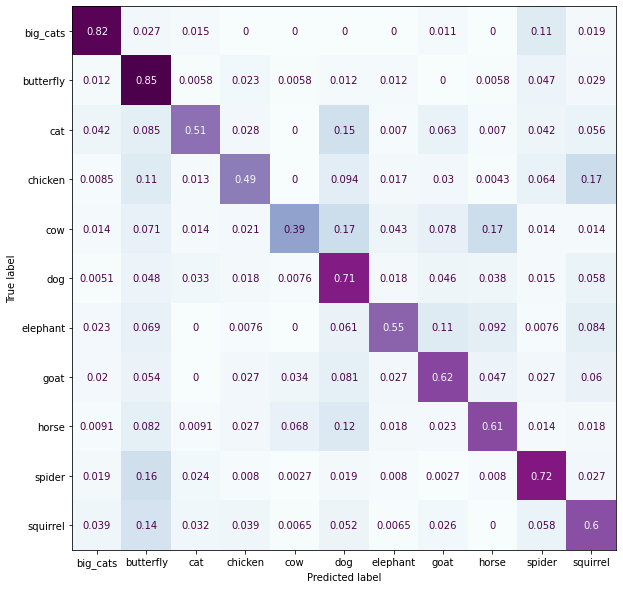

In [19]:
model_to_evaluate = 'VGGRes_2' # Can be changed to evaluate older models
try:
    loaded_model = keras.models.load_model(f'models/{model_number}/{model_to_evaluate}')
except:
    model = model

test_pred_raw = model.predict(valid_dataset.batch(128))
test_pred = np.argmax(test_pred_raw, axis=1)

kaggle.print_accuracy(valid_labels, test_pred)
kaggle.plot_confusion_matrix(valid_labels, test_pred)

### Get labels for Kaggle

In [ ]:
true_test_pred = np.argmax(model.predict(x_test_real), axis=1)

kaggle.save_test_pred(f'models/{model_number}/{model_name}_test_pred.csv', true_test_pred)